In [7]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from rl_working.ppo import PPO_make_train
import jax
from jax import jit
import wandb
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from rl_working.env_configs.configs import get_simple_stirap_params

In [8]:
class ConfigDict:
    def __init__(self, seed, lr, num_envs, num_updates, num_minibatches, clip_eps, ent_coef, max_grad_norm, 
                 layer_size, anneal_lr, env, noise, sigma_phase, sigma_amp, mu_phase, mu_amp, gamma_ss, 
                 omega_ss, delta_ss, x_detuning_ss, final_state_zero_ss, area_pen_ss, smoothness_pen_ss, 
                 smoothness_pen_ss_det, fix_endpoints_ss, smoothness_calc_amp, smoothness_calc_det, 
                 smoothness_cutoff_freq, log_fidelity, kernel_std_amp, kernel_std_freq,mxstep_solver, mx_step_penalty):
        
        self.seed = seed
        self.lr = lr
        self.num_envs = num_envs
        self.num_updates = num_updates
        self.num_minibatches = num_minibatches
        self.clip_eps = clip_eps
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm
        self.layer_size = layer_size
        self.anneal_lr = anneal_lr
        self.env = env
        self.noise = noise
        self.sigma_phase = sigma_phase
        self.sigma_amp = sigma_amp
        self.mu_phase = mu_phase
        self.mu_amp = mu_amp
        self.gamma_ss = gamma_ss
        self.omega_ss = omega_ss
        self.delta_ss = delta_ss
        self.x_detuning_ss = x_detuning_ss
        self.final_state_zero_ss = final_state_zero_ss
        self.area_pen_ss = area_pen_ss
        self.smoothness_pen_ss = smoothness_pen_ss
        self.smoothness_pen_ss_det = smoothness_pen_ss_det
        self.fix_endpoints_ss = fix_endpoints_ss
        self.smoothness_calc_amp = smoothness_calc_amp
        self.smoothness_calc_det = smoothness_calc_det
        self.smoothness_cutoff_freq = smoothness_cutoff_freq
        self.log_fidelity = log_fidelity
        self.kernel_std_amp = kernel_std_amp
        self.kernel_std_freq = kernel_std_freq
        self.mxstep_solver = mxstep_solver
        self.mx_step_penalty = mx_step_penalty

In [9]:
config_dict = ConfigDict(
    seed=10,
    lr=5e-4,
    num_envs=16,
    num_updates=5000,
    num_minibatches=4,
    clip_eps=0.2,
    ent_coef=0.0,
    max_grad_norm=0.5,
    layer_size=256,
    anneal_lr=0,
    env="simple_stirap", # Environment to run
    noise="None", # Noise type None, ou, or g (gaussian)
    sigma_phase=0,  #sigma for freq noise
    sigma_amp=0, #sigma for amplitude noise
    mu_phase=0, #mu for freq noise
    mu_amp=0, #mu for amplitude noise
    gamma_ss=1,  #gamma for lambda system
    omega_ss=30, #omega_max for lambda system
    delta_ss=20, #delta for lambda system
    x_detuning_ss=100, #detuning of excited state for lambda system
    final_state_zero_ss=0.0, #whether to optimise for full population transfer (0) or partial population transfer
    area_pen_ss=0.0, #pulse area penalty for lambda system
    smoothness_pen_ss=0.001, #smoothness penalty fro amplitude
    smoothness_pen_ss_det=0.001, #smoothness penalty for detuning
    fix_endpoints_ss=1, #boolean whether to fix endpoints of the pulses at zero
    smoothness_calc_amp="second_derivative", #smoothness calculation for amplitude
    smoothness_calc_det="second_derivative", #smoothness calculation for detuning
    smoothness_cutoff_freq=5.0, #max frequency for low pass filter
    log_fidelity=1, #bool whether to use log fidelity or not
    kernel_std_amp=4.0, #std for kernel smoothing for amplitude
    kernel_std_freq=4.0, #std for kernel smoothing for frequency
    mxstep_solver=1000, #max solver steps
    mx_step_penalty=-10.0 #max steps penalty
)

# Define the config dict for PPO training
config = {
    "LR": config_dict.lr,
    "NUM_ENVS": config_dict.num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": config_dict.num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": config_dict.num_minibatches,
    "MINIBATCH_SIZE": config_dict.num_envs // config_dict.num_minibatches,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": config_dict.clip_eps,
    "ENT_COEF": config_dict.ent_coef,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": config_dict.max_grad_norm,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": config_dict.layer_size,
    "ENV_NAME": config_dict.env,
    "ANNEAL_LR": config_dict.anneal_lr,
    "DEBUG": True,
    "DEBUG_NOJIT": False,
    "LOGGING": True,
    "LOG_FREQ": 10,
    "LOG_WAND": False,
    "LOCAL_LOGGING": True,
    "LOCAL_SAVE_NAME": "no_noise",
    "MU_PHASE": config_dict.mu_phase,
    "MU_AMP": config_dict.mu_amp,
    "ALPHA_PHASE": 0.1,
    "ALPHA_AMP": 0.1,
    "SIGMA_PHASE": config_dict.sigma_phase,
    "SIGMA_AMP": config_dict.sigma_amp,
}

config["ENV_PARAMS"] = get_simple_stirap_params(config_dict)

config["ENV_PARAMS"]["ou_noise_params"] = [
    config["MU_PHASE"],
    config["MU_AMP"],
    config["ALPHA_PHASE"],
    config["ALPHA_AMP"],
    config["SIGMA_PHASE"],
    config["SIGMA_AMP"],
]

In [ ]:
if config["DEBUG_NOJIT"]:
    jax.disable_jit(disable=True)

assert (config["NUM_MINIBATCHES"] * config["MINIBATCH_SIZE"] == config["NUM_STEPS"] * config["NUM_ENVS"])

rng = jax.random.PRNGKey(config_dict.seed)
rng, _rng = jax.random.split(rng)

single_train = jit(PPO_make_train(config))

print(f"Starting a Run of {config['NUM_UPDATES']} Updates")

# Add your own WandB configuration here
if config["LOG_WAND"]:
    wandb.init(project="", entity="", config=config)

outs = jax.block_until_ready(single_train(rng))

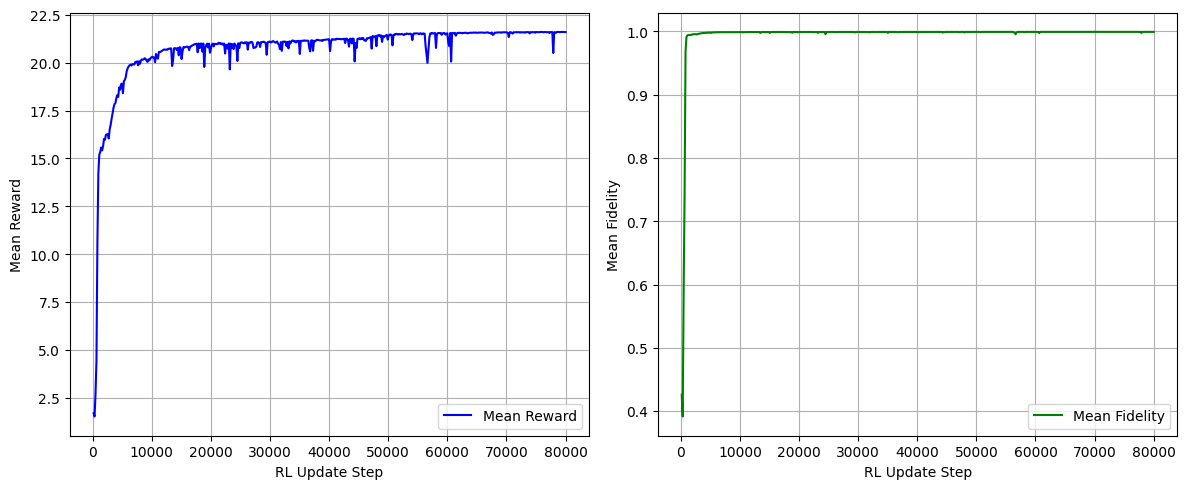

In [12]:
data_fpath = "episodic_data/simple_stirap/simple_stirap_no_noise.pkl"

with open(data_fpath, "rb") as file:
    episodic_data = pickle.load(file)

df = pd.DataFrame(episodic_data)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Mean Reward (Loss)
axes[0].plot(df["timestep"], df["mean_reward"], label="Mean Reward", color="blue")
axes[0].set_xlabel("RL Update Step")
axes[0].set_ylabel("Mean Reward")
axes[0].legend()
axes[0].grid()

# Plot Mean Fidelity
axes[1].plot(df["timestep"], df["mean_fidelity"], label="Mean Fidelity", color="green")
axes[1].set_xlabel("RL Update Step")
axes[1].set_ylabel("Mean Fidelity")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()